# Estimating the mass of 51 Peg b

The relationship between the amplitude, $k$, of the radial velocity, $v_R$ curve and the mass of the planet, assuming a circular orbit with period $P$ is given as:

$$
k = \left(\frac{2\pi G}{P}\right)^{1/3} \,\frac{M_P\sin i}{\left(M_P + M_\star\right)^{2/3}}
$$

We want to estimate $k$ and $P$ (in particular) from the following simple model for the radial velocity variation: 
$$
v_R = k\sin\left(\frac{2 \pi (t-t_0)}{P}\right) + v_0 = k\sin\left(2\pi (f+f_0)\right) + v_0
$$
where $f = t/P$. 


In [1]:
import numpy as np
from matplotlib import pyplot as plt

import emcee
import corner

In [5]:
# You might find these constants useful
#constants
G=6.674*1e-11   #m^3*s^-2*kg^-1
Mjupiter=1.898*1e27   #kg
Msun=1.989*1e30    #kg
Mearth=5.972*1e24    #kg

In [8]:
def load_mq95():
    """
    Load the file from Mayor & Queloz 1995.
    """

    fname = '../../../Datafiles/51Peg mayorqueloz95.dat'
    
    t, vr, dvr = np.loadtxt(fname, unpack=True)

    return {'t': t, 'vr': vr, 'dvr': dvr}


In [37]:
def radial_velocity(t, P, k, f0, v0):
    """Estimate the radial velocity for given inputs
    
    Parameters:
    -----------
    t : float
      Time in seconds
    P : float
      Period in days
    k : float
      Velocity amplitude in m/s
    v0 : float
      Velocity offset in m/s
      
    Output: 
    -------
    vr : float
      Radial velocity in m/s
    """

    P_sec = P*24*3600
    f = t/P_sec
    v_rad = k*np.sin(2.0*np.pi*(f-f0))+v0

    return v_rad

In [38]:
def lnL(theta, x, y, yerr):

    P, k, f0, v0 = theta
    
    inv_sigma2 = 1.0/(yerr**2)
    
    return -0.5*(np.sum((y-radial_velocity(x,P,k,f0,v0))**2*inv_sigma2))
    

def lnprior(theta):

    P, k, f0, v0 = theta
    if 4 < P < 4.5 and 54 < k < 59 and 0.9 < f0 < 1 and 6 < v0 < 9.5:
        return 0.0
    return -np.inf


def lnprob(theta, x, y, yerr):

    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnL(theta, x, y, yerr)


In [42]:
P_guess = 4.233 # Days
k_guess = 56.4
v0_guess = 7.7
f0_guess = 0.944
theta_initial = np.array([P_guess, k_guess, f0_guess, v0_guess])


ndim, nwalkers = 4, 100
pos=[theta_initial + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]



## Get the data

In [45]:
data = load_mq95()
t_days = data['t'] # days
t = t_days*24*3600
vr = data['vr']
dvr = data['dvr']

In [46]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(t, vr, dvr))
tmp = sampler.run_mcmc(pos, 5000)

## Look at the chains

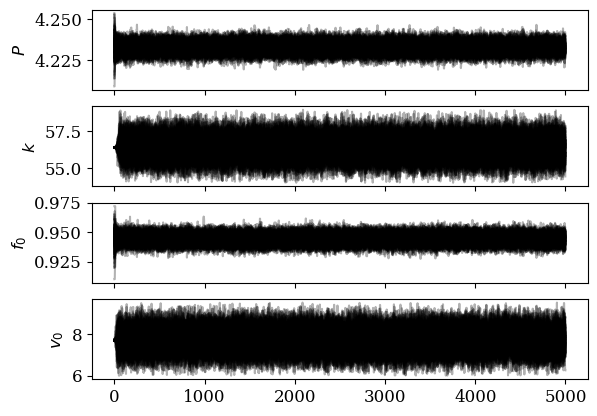

In [47]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True)

labels = ["$P$", "$k$", "$f_0$", "$v_0$"]
for i in range(4):
    axes[i].plot(sampler.chain[:, :, i].transpose(), color='black', alpha=0.3)
    axes[i].set_ylabel(labels[i])


In [48]:
n_burn = 100

In [49]:
samples = sampler.chain[:, n_burn:, :].reshape((-1, 4))

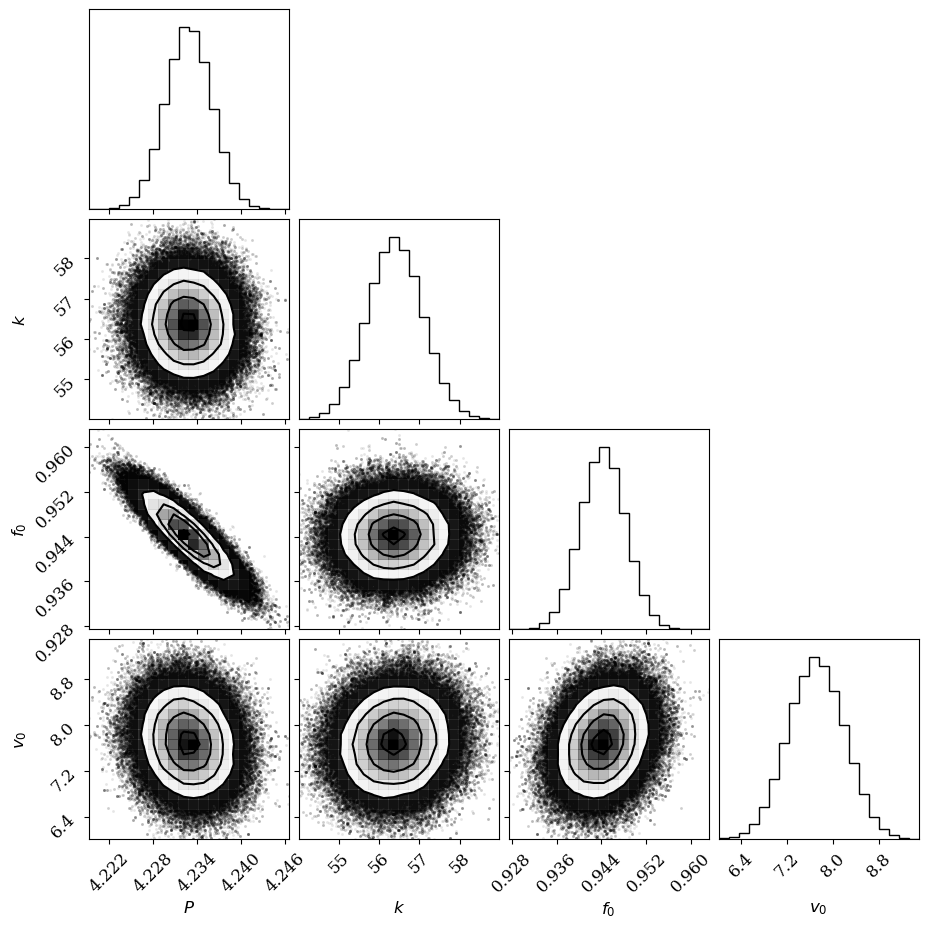

In [50]:
fig = corner.corner(samples, labels=labels)